<a href="https://colab.research.google.com/github/Jhorn-spec/GAN/blob/main/FashionGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Import Dependencies and Data
2. Viz Data and Build Dataset
3. Build Neural Network
  * Import Modelling Components
  * Build Generator
  * Build Discriminator
4. Construct Training Loop
  * Setup Losses and Optimizers
  * Build Subclassed Model
  * Build Callback
  * Train
  * Review Performance
5. Test Out The Generator
  * Generate Images
  * Save the Model


In [2]:
# !pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Bringing in tensorflow datasets for fashion mnist
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [3]:
# use the tensorflow datasets api to bring in the data source
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete1LS8TT/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete1LS8TT/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
ds.as_numpy_iterator().next()['label']

2

In [5]:
import numpy as np

In [6]:
# setup the data iterator
dataiterator = ds.as_numpy_iterator()

In [7]:
# Getting data out of the pipeline
dataiterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

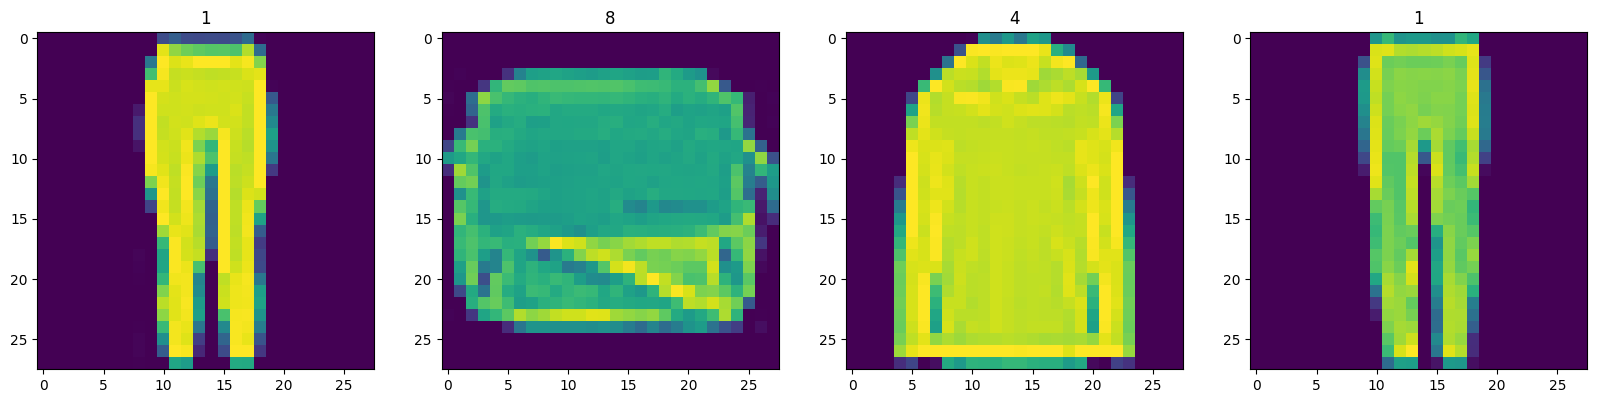

In [8]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    batch = dataiterator.next()
    ax[idx].imshow(np.squeeze(batch['image']))
    ax[idx].title.set_text(batch['label'])

In [9]:
  def scale_images(data):
    image = data['image']
    return image / 255

In [10]:
ds = tfds.load('fashion_mnist', split='train')
ds = ds.map(scale_images)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [11]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [12]:
# Build Neural Network
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [13]:
def build_generator():
  model = Sequential()

  model.add(Dense(7*7*128, input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  # Upsampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  # Upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  # Convolutional block 1
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # Convolutional block 2
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # Conv layer to get to one channel
  model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

  return model

In [14]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 2s 2s/step


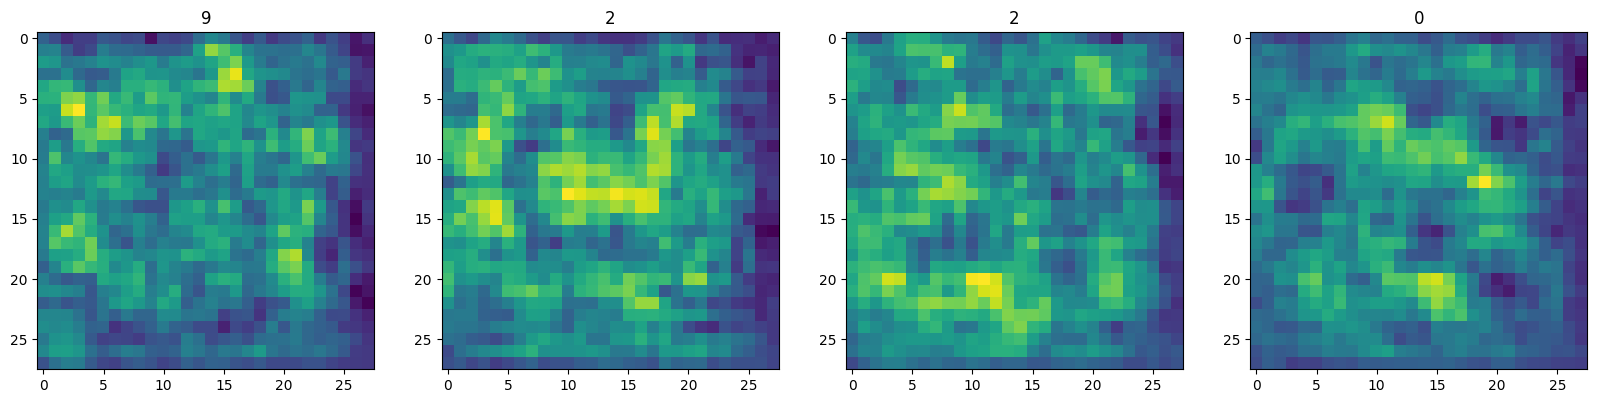

In [15]:
img = generator.predict(np.random.randn(4, 128, 1))

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(img):
    batch = dataiterator.next()
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(batch['label'])

In [16]:
# img = generator.predict(np.random.randn(4, 128, 1))
# img.shape

In [17]:
# Build Descriminator
def build_discriminator():
  model = Sequential()

  # First Conv Block
  model.add(Conv2D(32, 5, input_shape=(28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Second Conv Block
  model.add(Conv2D(64, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Third Conv Block
  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Fourth Conv Block
  model.add(Conv2D(256, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Flatten, then pass to dense layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [18]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [19]:
discriminator.predict(np.expand_dims(img,0))
# discriminator.predict(img)

1/1 [==============================] - 0s 381ms/step


array([[0.5025489]], dtype=float32)

In [20]:
# Training GAN Loop
# Being able to learn the speed with which the discriminator trains and the generator learns
# Being able to train them side by side
# Inject some random noise into the dsicriminator to slow it down

# setup losses and optimizers
# Adam is going to ne the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [21]:
# the learning rate for the generator is going to be faster than that of the
# dscriminator, so the discriminator will not go too fast
g_opt = Adam(1e-3)
d_opt = Adam(1e-4)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [22]:
from tensorflow.keras.models import Model

In [23]:
class FashionGAN(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    # Pass thrugh args and kwargs to base class
    super().__init__(*args, **kwargs)

    # Create attributes for gen and disc
    self.generator = generator
    self.discriminator = discriminator

  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    # compile with base class
    super().compile(*args, **kwargs)

    # create attributes for losses and optimizers
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss


  def train_step(self, batch):
    # Get the data
    real_images = batch
    fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

    # Train the discriminator
    with tf.GradientTape() as d_tape:
      # Pass the real and fake images to the discriminator model
      yhat_real = self.discriminator(real_images, training=True)
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

      # create labels for real and fake images
      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

      # Add some noise to the outputs
      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real, noise_fake], axis=0)

      # calculate loss
      total_d_loss = self.d_loss(y_realfake, yhat_realfake)

    # Apply backpropagation - nn learn
    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_weights)
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_weights))

    # Train the generator
    with tf.GradientTape() as g_tape:
      # Generate some new images
      gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)
      # Created the predicted labels
      predicted_labels = self.discriminator(gen_images, training=False)

      # Calculate loss - trick to training to fake out the discriminator
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

    # Apply backprop
    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

    return {"d_loss": total_d_loss, "g_loss": total_g_loss}

In [24]:
# create an instance of subclassed model
fashgan = FashionGAN(generator, discriminator)

In [25]:
# compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [26]:
# Build Callback
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [31]:
os.makedirs('generated_img', exist_ok=True)

In [33]:
class ModelMonitor(Callback):
  def __init__(self, num_img=3, latent_dim=128): # the latent dim is for the generator
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    for i in range(self.num_img):
      img = array_to_img(generated_images[i])
      img.save(os.path.join('generated_img', f'generated_img_{epoch}_{i}.png'))

In [34]:
# Train
# Recommend 2000 epochs
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
  6/469 [..............................] - ETA: 1:13 - d_loss: 0.2670 - g_loss: 2.7286

469/469 [==============================] - 77s 164ms/step - d_loss: 0.2664 - g_loss: 2.7081
Epoch 2/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.2668 - g_loss: 2.6815
Epoch 3/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.2671 - g_loss: 2.6635
Epoch 4/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.2665 - g_loss: 2.6479
Epoch 5/20
114/469 [======>.......................] - ETA: 57s - d_loss: 0.2669 - g_loss: 2.6514

KeyboardInterrupt: 

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1]

In [ ]:
# generator.load_weights('generator.h5')